# Convolutional Neural Network Model - Hiperparameters Tuning

Input: testing different number of months in input using single PCA

Output: optimal max-shape portfolio with tight restrictions for the next period

## Data Pre-processing

In [1]:
import numpy as np

from keras.models import Sequential
from keras.layers import Dense, Flatten, Conv1D, Dropout
from keras.regularizers import L2
from keras.optimizers import Adam

from sklearn.model_selection import StratifiedKFold
import keras_tuner

from helper_functions import train_and_evaluate_model, calculate_returns_for_model, daily_to_annual_returns

In [2]:
import os
os.chdir(os.path.expanduser('../data'))

from dotenv import load_dotenv
load_dotenv()

from DataProvider import DataProvider

In [3]:
data_provider = DataProvider()
y = data_provider.get_formatted_targets()

c:\Users\lukas\Documents\Master mAI-X\TFM\venv\Lib\site-packages\cvxpy\problems\problem.py:1403: UserWarning: Solution may be inaccurate. Try another solver, adjusting the solver settings, or solve with verbose=True for more information.
  warnings.warn(
c:\Users\lukas\Documents\Master mAI-X\TFM\venv\Lib\site-packages\cvxpy\problems\problem.py:1403: UserWarning: Solution may be inaccurate. Try another solver, adjusting the solver settings, or solve with verbose=True for more information.
  warnings.warn(
c:\Users\lukas\Documents\Master mAI-X\TFM\venv\Lib\site-packages\cvxpy\problems\problem.py:1403: UserWarning: Solution may be inaccurate. Try another solver, adjusting the solver settings, or solve with verbose=True for more information.
  warnings.warn(


## Cross validation to calculate optimal number of months

In [4]:
df_countries, _ = data_provider.get_etf_data()
days_to_recalculate = data_provider.get_days_to_recalculate()

val_split = int(0.7 * y.shape[0])
test_split = int(0.8 * y.shape[0])
dates_for_validation = days_to_recalculate[val_split:test_split]

df_prices_val = df_countries[dates_for_validation[0]:]
df_returns_val = np.log(df_prices_val).diff().fillna(0)

In [6]:
max_sharpe = 0
best_month_no = 0

for no_months in range(3, 10):
    print(f'CNN Model for {no_months} months')
    x = data_provider.get_formatted_features(no_months=no_months)
    x_train, y_train, x_val, y_val, x_test, y_test = data_provider.train_train_split(x, y)

    skf = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)
    skf.get_n_splits(x_train, y_train)

    sum_sharpe = 0
    for _, (train_index, val_index) in enumerate(skf.split(x_train, np.zeros(y_train.shape[0]))):
        x_train_fold = x_train[train_index]
        y_train_fold = y_train[train_index]
        x_val_fold = x_train[val_index]
        y_val_fold = y_train[val_index]

        model = Sequential((
            Conv1D(32, 3, input_shape=x_train.shape[1:]),
            Flatten(),
            Dropout(0.3),
            Dense(16, activation='relu', kernel_regularizer=L2(0.3)),
            Dense(y_train.shape[1], activation='softmax')
        ))
        model.compile(optimizer=Adam(learning_rate=1e-3),
                      loss='mean_squared_error')
        _ = model.fit(x_train_fold, y_train_fold,
                      validation_data=(x_val_fold, y_val_fold),
                      epochs=200, verbose=False)

        total_ret_val, _ = calculate_returns_for_model(
            model, x_val, dates_for_validation, df_returns_val)

        annual_returns = daily_to_annual_returns(total_ret_val)
        annual_volatility = total_ret_val.std()*np.sqrt(252)
        annual_sharpe_val = annual_returns/annual_volatility
        sum_sharpe += annual_sharpe_val
        print('Sharpe fold', annual_sharpe_val)

    mean_sharpe_val = sum_sharpe/5
    print('Mean Sharpe', mean_sharpe_val)
    if mean_sharpe_val > max_sharpe:
        max_sharpe = mean_sharpe_val
        best_month_no = no_months

print('Best number of months', best_month_no, 'with mean Sharpe ratio', max_sharpe)

CNN Model for 3 months


c:\Users\lukas\Documents\Master mAI-X\TFM\venv\Lib\site-packages\keras\src\layers\convolutional\base_conv.py:99: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 34ms/step
Sharpe fold 0.39044356011018433
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 33ms/step
Sharpe fold 0.3964710803176926
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 31ms/step
Sharpe fold 0.39535053450816815
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 34ms/step
Sharpe fold 0.3816360063806048
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 31ms/step
Sharpe fold 0.380976797743729
Mean Sharpe 0.3889755958120758
CNN Model for 4 months


c:\Users\lukas\Documents\Master mAI-X\TFM\venv\Lib\site-packages\keras\src\layers\convolutional\base_conv.py:99: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 31ms/step
Sharpe fold 0.3902433098178157
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 33ms/step
Sharpe fold 0.38514770607144827
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 34ms/step
Sharpe fold 0.40268803121948743
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 34ms/step
Sharpe fold 0.3756073142493797
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 32ms/step
Sharpe fold 0.39636110980125194
Mean Sharpe 0.39000949423187664
CNN Model for 5 months


c:\Users\lukas\Documents\Master mAI-X\TFM\venv\Lib\site-packages\keras\src\layers\convolutional\base_conv.py:99: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 32ms/step
Sharpe fold 0.40128061384899
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 31ms/step
Sharpe fold 0.39834102045230685
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 36ms/step
Sharpe fold 0.39432041409990576
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 33ms/step
Sharpe fold 0.3860382953186419
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 33ms/step
Sharpe fold 0.37608665481830267
Mean Sharpe 0.3912133997076294
CNN Model for 6 months


c:\Users\lukas\Documents\Master mAI-X\TFM\venv\Lib\site-packages\keras\src\layers\convolutional\base_conv.py:99: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 31ms/step
Sharpe fold 0.3951949281754986
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step
Sharpe fold 0.40759317845392184
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 33ms/step
Sharpe fold 0.38013570553340037
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 30ms/step
Sharpe fold 0.36402902745497306
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 30ms/step
Sharpe fold 0.3667416765448597
Mean Sharpe 0.3827389032325307
CNN Model for 7 months


c:\Users\lukas\Documents\Master mAI-X\TFM\venv\Lib\site-packages\keras\src\layers\convolutional\base_conv.py:99: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 31ms/step
Sharpe fold 0.4101502814329681
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 33ms/step
Sharpe fold 0.4337820456997409
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 32ms/step
Sharpe fold 0.39411309282904583
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 31ms/step
Sharpe fold 0.39316091231385086
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 33ms/step
Sharpe fold 0.3954166733920955
Mean Sharpe 0.40532460113354024
CNN Model for 8 months


c:\Users\lukas\Documents\Master mAI-X\TFM\venv\Lib\site-packages\keras\src\layers\convolutional\base_conv.py:99: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 33ms/step
Sharpe fold 0.39622504654443075
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 35ms/step
Sharpe fold 0.41448404226639135
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 35ms/step
Sharpe fold 0.39632006445729134
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 27ms/step
Sharpe fold 0.3969703421482222
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 44ms/step
Sharpe fold 0.38949373079538513
Mean Sharpe 0.39869864524234416
CNN Model for 9 months


c:\Users\lukas\Documents\Master mAI-X\TFM\venv\Lib\site-packages\keras\src\layers\convolutional\base_conv.py:99: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 31ms/step
Sharpe fold 0.38824731987415473
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 37ms/step
Sharpe fold 0.38786471525899574
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 31ms/step
Sharpe fold 0.4251225615507908
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 40ms/step
Sharpe fold 0.39860144768356376
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 39ms/step
Sharpe fold 0.4251255160648232
Mean Sharpe 0.4049923120864657
Best number of months 7 with mean Sharpe ratio 0.40532460113354024


In [4]:
best_month_no = 7

x = data_provider.get_formatted_features(no_months=best_month_no)
x_train, y_train, x_val, y_val, x_test, y_test = data_provider.train_train_split(x, y)

## Hiperparameters Tuning

In [5]:
def build_model(hp):
    model = Sequential()
    model.add(Conv1D(hp.Choice('conv1_units', [32, 64, 128, 256]), 3,
                     input_shape=x_train.shape[1:]))

    if hp.Boolean("second_layer"):
        model.add(Conv1D(hp.Choice('conv2_units', [32, 64, 128, 256]), 3))

    model.add(Flatten())
    model.add(Dropout(hp.Choice('dropout', [0.0, 0.1, 0.2, 0.3])))

    model.add(Dense(hp.Choice('dense_units', [32, 64, 128]), activation='relu'))
    model.add(Dense(y_train.shape[1], activation='softmax'))
    model.compile(loss='mse')
    return model

In [6]:
tuner = keras_tuner.RandomSearch(
    build_model,
    objective='val_loss',
    max_trials=300,
    directory='tuning',
    project_name='model_cnn')

Reloading Tuner from tuning\model_cnn\tuner0.json


In [7]:
tuner.search_space_summary()

Search space summary
Default search space size: 5
conv1_units (Choice)
{'default': 32, 'conditions': [], 'values': [32, 64, 128, 256], 'ordered': True}
second_layer (Boolean)
{'default': False, 'conditions': []}
dropout (Choice)
{'default': 0.0, 'conditions': [], 'values': [0.0, 0.1, 0.2, 0.3], 'ordered': True}
dense_units (Choice)
{'default': 32, 'conditions': [], 'values': [32, 64, 128], 'ordered': True}
conv2_units (Choice)
{'default': 32, 'conditions': [], 'values': [32, 64, 128, 256], 'ordered': True}


In [8]:
tuner.search(x_train, y_train, epochs=150, validation_data=(x_val, y_val))

In [9]:
tuner.results_summary()

Results summary
Results in tuning\model_cnn
Showing 10 best trials
Objective(name="val_loss", direction="min")

Trial 209 summary
Hyperparameters:
conv1_units: 256
second_layer: False
dropout: 0.1
dense_units: 32
conv2_units: 128
Score: 0.0004806154465768486

Trial 055 summary
Hyperparameters:
conv1_units: 128
second_layer: True
dropout: 0.2
dense_units: 128
conv2_units: 256
Score: 0.0004806294455192983

Trial 047 summary
Hyperparameters:
conv1_units: 256
second_layer: False
dropout: 0.3
dense_units: 64
conv2_units: 32
Score: 0.00048525843885727227

Trial 027 summary
Hyperparameters:
conv1_units: 256
second_layer: False
dropout: 0.3
dense_units: 64
conv2_units: 64
Score: 0.0004856258456129581

Trial 096 summary
Hyperparameters:
conv1_units: 256
second_layer: True
dropout: 0.1
dense_units: 64
conv2_units: 32
Score: 0.0004888686817139387

Trial 275 summary
Hyperparameters:
conv1_units: 256
second_layer: False
dropout: 0.3
dense_units: 128
conv2_units: 32
Score: 0.0004902514046989381

Tri

## Best Model training

c:\Users\lukas\Documents\Master mAI-X\TFM\venv\Lib\site-packages\keras\src\layers\convolutional\base_conv.py:99: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(


Model: "sequential_2"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ conv1d_4 (Conv1D)               │ (None, 5, 128)         │        10,496 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv1d_5 (Conv1D)               │ (None, 3, 64)          │        24,640 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten_2 (Flatten)             │ (None, 192)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_2 (Dropout)             │ (None, 192)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_4 (Dense)                 │ (None, 32)             │         6,176 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_5 (Dense)                 │ (None, 27)             │           891 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 42,203 (164.86 KB)

 Trainable params: 42,203 (164.86 KB)

 Non-trainable params: 0 (0.00 B)


Epoch 1/200
7/7 ━━━━━━━━━━━━━━━━━━━━ 1s 17ms/step - loss: 0.0083 - val_loss: 0.0024 - learning_rate: 0.0010
Epoch 2/200
7/7 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 0.0040 - val_loss: 0.0013 - learning_rate: 0.0010
Epoch 3/200
7/7 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 0.0037 - val_loss: 0.0017 - learning_rate: 0.0010
Epoch 4/200
7/7 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 0.0027 - val_loss: 0.0013 - learning_rate: 0.0010
Epoch 5/200
7/7 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - loss: 0.0025 - val_loss: 0.0016 - learning_rate: 0.0010
Epoch 6/200
7/7 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 0.0020 - val_loss: 9.3337e-04 - learning_rate: 0.0010
Epoch 7/200
7/7 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - loss: 0.0018 - val_loss: 7.9502e-04 - learning_rate: 0.0010
Epoch 8/200
7/7 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - loss: 0.0016 - val_loss: 8.2888e-04 - learning_rate: 0.0010
Epoch 9/200
7/7 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 0.0013 - val_loss: 0.0015 - learning_rate: 0.0010
Epoch 10/200
7/7 ━━━━━━

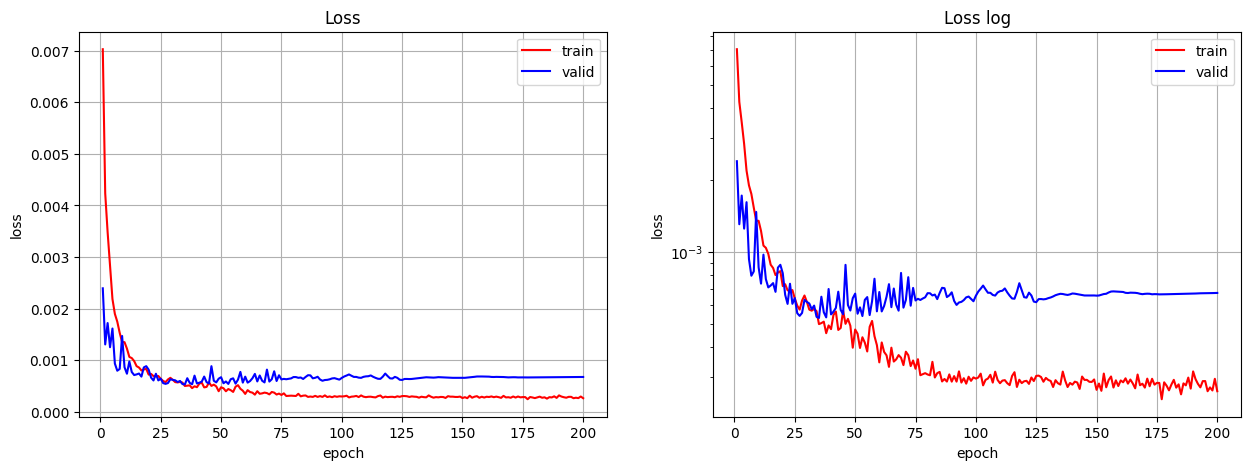

In [14]:
# best_model = tuner.get_best_models()[0]

best_model = Sequential((
    Conv1D(128, 3, input_shape=x_train.shape[1:]),
    Conv1D(64, 3),
    Flatten(),
    Dropout(0.2),
    Dense(32, activation='relu'),
    Dense(y_train.shape[1], activation='softmax')
))

train_and_evaluate_model(best_model, x_train, y_train,
                         x_val, y_val, x_test, y_test)

## Backtesting

1/2 ━━━━━━━━━━━━━━━━━━━━ 0s 44ms/stepWARNING:tensorflow:6 out of the last 6 calls to <function TensorFlowTrainer.make_predict_function.<locals>.one_step_on_data_distributed at 0x00000213880A0E00> triggered tf.function retracing. Tracing is expensive and the excessive number of tracings could be due to (1) creating @tf.function repeatedly in a loop, (2) passing tensors with different shapes, (3) passing Python objects instead of tensors. For (1), please define your @tf.function outside of the loop. For (2), @tf.function has reduce_retracing=True option that can avoid unnecessary retracing. For (3), please refer to https://www.tensorflow.org/guide/function#controlling_retracing and https://www.tensorflow.org/api_docs/python/tf/function for  more details.
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step


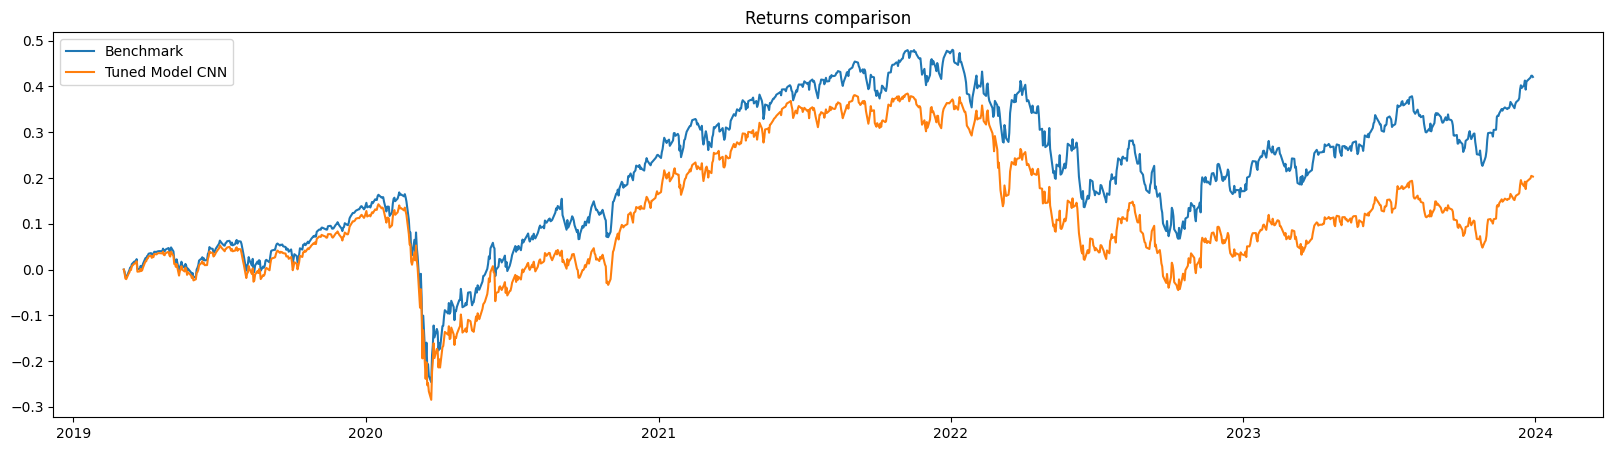

,Annual Returns,Annual Volatility,Sharpe Ratio,Sortino Ratio,Max Drawdown,Max Time Under Water,Calmar Ratio,Information Ratio
Benchmark,0.076754,0.203326,0.377494,0.442047,-0.354829,500.0,0.216313,0
Tuned Model CNN,0.039766,0.207144,0.191972,0.222759,-0.373757,538.0,0.106394,-0.802371


In [15]:
from helper_functions import run_full_backtesting

models = {'Tuned Model CNN': best_model}
df_results = run_full_backtesting(data_provider, x_test, models)
df_results